<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/bawang_putih_us.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [3]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [4]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [5]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fd0f27ee370>)

In [6]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [7]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [8]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.bawang_putih_ukuran_sedang.values
date = dataset.index

## Train test val split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


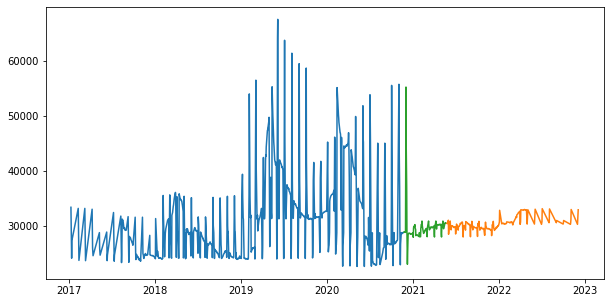

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [11]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [12]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_baput_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 48ms/step - loss: 0.0972 - mae: 0.2384 - mape: 239315.6094 - val_loss: 0.0343 - val_mae: 0.1839 - val_mape: 85.8530
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0750 - mae: 0.1959 - mape: 336241.2188 - val_loss: 0.0192 - val_mae: 0.1371 - val_mape: 63.7175
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0606 - mae: 0.1737 - mape: 905900.1875 - val_loss: 0.0110 - val_mae: 0.1028 - val_mape: 47.4943
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0523 - mae: 0.1648 - mape: 1063410.3750 - val_loss: 0.0062 - val_mae: 0.0759 - val_mape: 34.7479
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0468 - mae: 0.1629 - mape: 1307223.2500 - val_loss: 0.0034 - val_mae: 0.0552 - val_mape: 25.0515
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0434 - mae: 0.1633 - mape: 1544062.8750 - val_loss: 0.0019 - val_ma

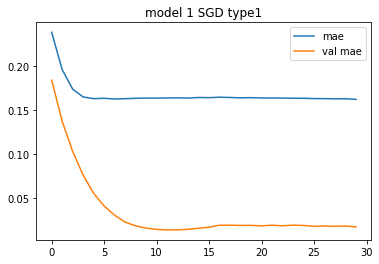

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
2252.4563 7.5473127 2446.4764458297977


,date,actual,prediction
0,2021-05-20,30450,32559.236328
1,2021-05-21,30450,32523.238281
2,2021-05-24,30450,32544.583984
3,2021-05-25,30400,32510.556641
4,2021-05-27,30450,32536.125000
...,...,...,...
229,2022-11-02,30550,32832.187500
230,2022-11-03,31100,32829.152344
231,2022-11-04,32950,32809.851562
232,2022-12-01,30250,32809.914062


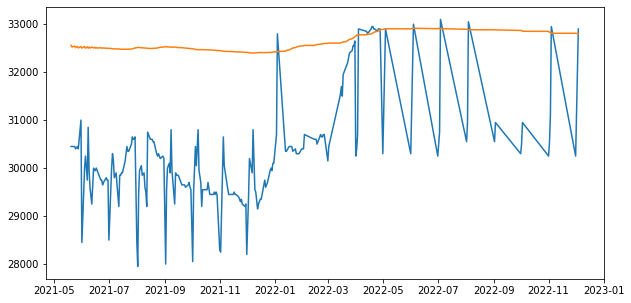

In [ ]:
prediction = forecast_predict(model, test_baput_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_baput = pd.DataFrame()
data_new_baput['date'] = y_test
data_new_baput['actual'] = x_test
data_new_baput['prediction'] = data_result
data_new_baput.to_csv('baput_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_baput.date, data_new_baput.actual)
plt.plot(data_new_baput.date, data_new_baput.prediction)
data_new_baput

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0255 - mae: 0.1208 - mape: 728826.5625 - val_loss: 4.3898e-04 - val_mae: 0.0153 - val_mape: 7.8487
Epoch 2/30
718/718 [==============================] - 7s 10ms/step - loss: 0.0245 - mae: 0.1153 - mape: 738963.1875 - val_loss: 5.0176e-04 - val_mae: 0.0135 - val_mape: 7.2873
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0238 - mae: 0.1146 - mape: 801266.1875 - val_loss: 4.4166e-04 - val_mae: 0.0148 - val_mape: 7.6504
Epoch 4/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0232 - mae: 0.1125 - mape: 747783.5625 - val_loss: 6.0256e-04 - val_mae: 0.0214 - val_mape: 10.2707
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0228 - mae: 0.1107 - mape: 786779.8750 - val_loss: 5.2629e-04 - val_mae: 0.0195 - val_mape: 9.4677
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0224 - mae: 0.1099 - mape: 812177.3125 - val_lo

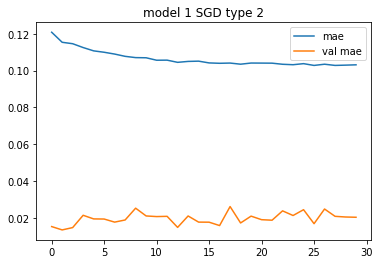

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
625.42554 2.0375767 823.4234557625864


,date,actual,prediction
0,2021-05-20,30450,32559.236328
1,2021-05-21,30450,32523.238281
2,2021-05-24,30450,32544.583984
3,2021-05-25,30400,32510.556641
4,2021-05-27,30450,32536.125000
...,...,...,...
229,2022-11-02,30550,32832.187500
230,2022-11-03,31100,32829.152344
231,2022-11-04,32950,32809.851562
232,2022-12-01,30250,32809.914062


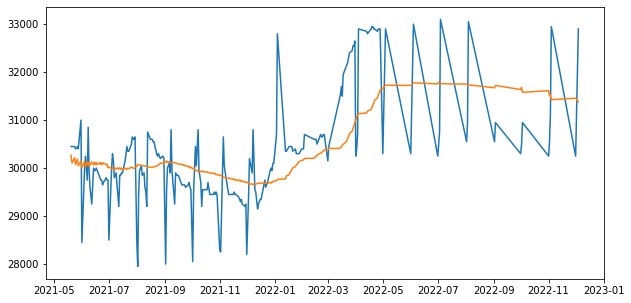

In [ ]:
win_size1 = 60
test_baput_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_baput_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_baput_1 = pd.DataFrame()
data_new_baput_1['actual'] = x_test
data_new_baput_1['prediction'] = data_result_1
data_new_baput_1.to_csv('baput_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_baput_1.actual)
plt.plot(y_test, data_new_baput_1.prediction)
data_new_baput

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0292 - mae: 0.1234 - mape: 1529299.0000 - val_loss: 4.4761e-04 - val_mae: 0.0154 - val_mape: 7.9096
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0290 - mae: 0.1255 - mape: 1562250.7500 - val_loss: 4.8497e-04 - val_mae: 0.0136 - val_mape: 7.2829
Epoch 3/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0290 - mae: 0.1261 - mape: 1574464.0000 - val_loss: 4.8356e-04 - val_mae: 0.0136 - val_mape: 7.2865
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0290 - mae: 0.1269 - mape: 1578310.6250 - val_loss: 5.5145e-04 - val_mae: 0.0140 - val_mape: 7.5746
Epoch 5/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0290 - mae: 0.1268 - mape: 1585691.5000 - val_loss: 5.0304e-04 - val_mae: 0.0134 - val_mape: 7.2542
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0290 - mae: 0.1266 - mape: 1578321.5000 - val_loss

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('baput kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_baput_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_baput_2 = pd.DataFrame()
# data_new_baput1['date'] = date_test
data_new_baput_2['actual'] = x_test
data_new_baput_2['prediction'] = data_result_2
data_new_baput_2.to_csv('baput_model1_sgd_type3')

plt.plot(y_test, data_new_baput_2.actual)
plt.plot(y_test, data_new_baput_2.prediction)
data_new_baput_2

### Adam

In [13]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 39ms/step - loss: 0.0770 - mae: 0.2035 - mape: 373828.9062 - val_loss: 0.0209 - val_mae: 0.1430 - val_mape: 66.4837
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0503 - mae: 0.1597 - mape: 1087643.5000 - val_loss: 0.0044 - val_mae: 0.0630 - val_mape: 28.6227
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0363 - mae: 0.1550 - mape: 2359592.5000 - val_loss: 4.6115e-04 - val_mae: 0.0172 - val_mape: 8.5736
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0331 - mae: 0.1509 - mape: 2661074.2500 - val_loss: 4.4267e-04 - val_mae: 0.0159 - val_mape: 8.0821
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0327 - mae: 0.1495 - mape: 2762752.0000 - val_loss: 4.4107e-04 - val_mae: 0.0155 - val_mape: 7.9273
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0329 - mae: 0.1515 - mape: 2778050.0000 - val_loss: 4.449

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('baput kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a = forecast_predict(model_a, test_baput_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_baput_a = pd.DataFrame()
# data_new_baput1['date'] = date_test
data_new_baput_a['actual'] = x_test
data_new_baput_a['prediction'] = data_result_a
data_new_baput_a.to_csv('baput_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_baput_a.actual)
plt.plot(y_test, data_new_baput_a.prediction)
data_new_baput_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0203 - mae: 0.0972 - mape: 799034.5000 - val_loss: 0.0026 - val_mae: 0.0464 - val_mape: 23.0959
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0200 - mae: 0.0966 - mape: 716636.0000 - val_loss: 4.9977e-04 - val_mae: 0.0132 - val_mape: 7.1257
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0200 - mae: 0.0962 - mape: 797351.2500 - val_loss: 5.5924e-04 - val_mae: 0.0142 - val_mape: 7.7059
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0200 - mae: 0.0956 - mape: 867698.8750 - val_loss: 0.0017 - val_mae: 0.0361 - val_mape: 18.2090
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0199 - mae: 0.0968 - mape: 831558.6250 - val_loss: 4.5274e-04 - val_mae: 0.0138 - val_mape: 7.3177
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0198 - mae: 0.0963 - mape: 864698.3125 - val_loss: 7.63

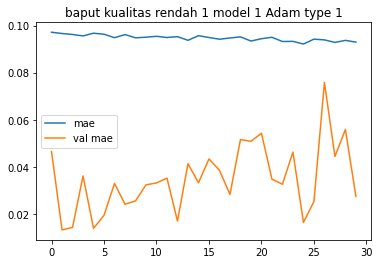

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('baput kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1151.2709 3.8326116 1493.0911727017879


,actual,prediction
0,30450,31195.873047
1,30450,31062.197266
2,30450,31256.808594
3,30400,31058.169922
4,30450,31273.630859
...,...,...
229,30550,34425.011719
230,31100,34332.074219
231,32950,34217.632812
232,30250,34128.765625


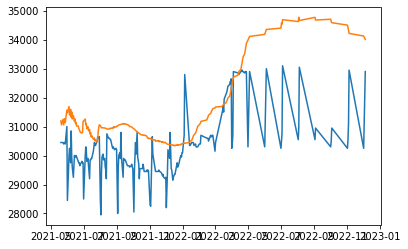

In [ ]:
prediction_a1 = forecast_predict(model_a, test_baput_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_baput_a1 = pd.DataFrame()
data_new_baput_a1['actual'] = x_test
data_new_baput_a1['prediction'] = data_result_a1
data_new_baput_a1.to_csv('baput_model1_adam_type2.csv')

plt.plot(y_test, data_new_baput_a1.actual)
plt.plot(y_test, data_new_baput_a1.prediction)
data_new_baput_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0252 - mae: 0.1068 - mape: 1301435.1250 - val_loss: 0.0041 - val_mae: 0.0603 - val_mape: 29.5791
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0249 - mae: 0.1068 - mape: 1227394.6250 - val_loss: 0.0061 - val_mae: 0.0749 - val_mape: 36.4807
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0248 - mae: 0.1092 - mape: 1364589.8750 - val_loss: 0.0048 - val_mae: 0.0662 - val_mape: 32.3486
Epoch 4/30
84/84 [==============================] - 2s 18ms/step - loss: 0.0247 - mae: 0.1076 - mape: 1297839.8750 - val_loss: 0.0038 - val_mae: 0.0579 - val_mape: 28.4283
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0246 - mae: 0.1067 - mape: 1281869.1250 - val_loss: 0.0059 - val_mae: 0.0735 - val_mape: 35.7825
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0246 - mae: 0.1070 - mape: 1263473.2500 - val_loss: 0.0060 - val_

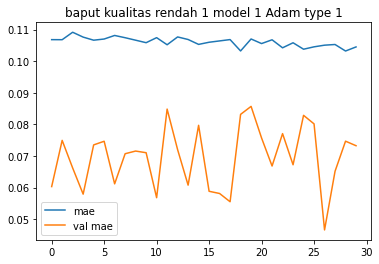

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('baput kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2178.2417 7.2129583 2560.4244765272806


,actual,prediction
0,30450,32534.087891
1,30450,32615.314453
2,30450,32800.625000
3,30400,32768.328125
4,30450,32966.128906
...,...,...
229,30550,37178.832031
230,31100,37066.398438
231,32950,37011.339844
232,30250,36868.718750


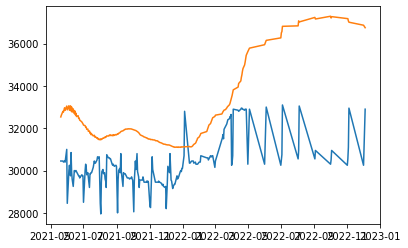

In [ ]:
prediction_a2 = forecast_predict(model_a, test_baput_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_baput_a2 = pd.DataFrame()
# data_new_baput1['date'] = date_test
data_new_baput_a2['actual'] = x_test
data_new_baput_a2['prediction'] = data_result_a2
data_new_baput_a2.to_csv('baput_model1_adam_type3.csv')

plt.plot(y_test, data_new_baput_a2.actual)
plt.plot(y_test, data_new_baput_a2.prediction)
data_new_baput_a2

## model 1

### Adam

In [14]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.0778 - mae: 0.2031 - mape: 754760.9375 - val_loss: 0.0139 - val_mae: 0.1162 - val_mape: 53.8162
Epoch 2/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0392 - mae: 0.1618 - mape: 2292084.2500 - val_loss: 0.0022 - val_mae: 0.0440 - val_mape: 20.0481
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0351 - mae: 0.1530 - mape: 2773507.2500 - val_loss: 9.5519e-04 - val_mae: 0.0290 - val_mape: 13.5046
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0352 - mae: 0.1492 - mape: 3189629.0000 - val_loss: 0.0021 - val_mae: 0.0428 - val_mape: 19.4838
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0348 - mae: 0.1532 - mape: 2941140.0000 - val_loss: 0.0011 - val_mae: 0.0318 - val_mape: 14.7250
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0334 - mae: 0.1499 - mape: 2818700.2500 - val_loss: 5.7228e-04

17/17 [==============================] - 0s 7ms/step - loss: 0.0740 - mae: 0.2267 - mape: 32.1289


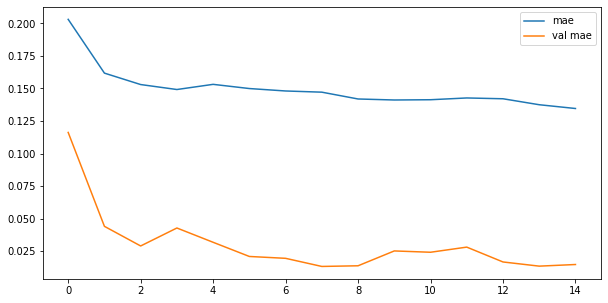

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_baput_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_baput1 = pd.DataFrame()
data_new_baput1['actual'] = x_test
data_new_baput1['prediction'] = data_result1
data_new_baput1.to_csv('baput_model2_adam_type1.csv')

data_new_baput1

131/131 [==============================] - 2s 8ms/step
1270.9404 4.1211834 1486.43684695987


,actual,prediction
0,30450,29207.337891
1,30450,29490.417969
2,30450,29141.201172
3,30400,29446.830078
4,30450,29072.193359
...,...,...
229,30550,30146.537109
230,31100,29946.332031
231,32950,30060.320312
232,30250,29849.447266


In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_baput1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_baput1['prediction'], '-o')

#### Type 2

In [15]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 27s 15ms/step - loss: 0.0224 - mae: 0.1081 - mape: 753241.2500 - val_loss: 0.0022 - val_mae: 0.0438 - val_mape: 19.9464
Epoch 2/15
718/718 [==============================] - 8s 11ms/step - loss: 0.0209 - mae: 0.1013 - mape: 781021.3125 - val_loss: 4.4074e-04 - val_mae: 0.0150 - val_mape: 7.7714
Epoch 3/15
718/718 [==============================] - 8s 11ms/step - loss: 0.0214 - mae: 0.1033 - mape: 869030.5000 - val_loss: 4.3779e-04 - val_mae: 0.0160 - val_mape: 8.1283
Epoch 4/15
718/718 [==============================] - 8s 11ms/step - loss: 0.0203 - mae: 0.0976 - mape: 737321.6250 - val_loss: 7.1146e-04 - val_mae: 0.0180 - val_mape: 9.5837
Epoch 5/15
718/718 [==============================] - 8s 11ms/step - loss: 0.0203 - mae: 0.0986 - mape: 779572.9375 - val_loss: 6.9118e-04 - val_mae: 0.0174 - val_mape: 9.2782
Epoch 6/15
718/718 [==============================] - 8s 11ms/step - loss: 0.0199 - mae: 0.0981 - mape: 866182.6250 - val_

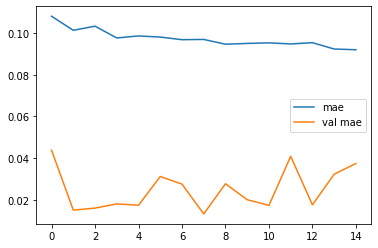

In [16]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 4ms/step
1481.393 4.914077 1829.1556112042517


,actual,prediction
0,30450,30451.251953
1,30450,30913.255859
2,30450,31214.052734
3,30400,31393.742188
4,30450,31884.382812
...,...,...
229,30550,34587.312500
230,31100,34513.398438
231,32950,34235.859375
232,30250,34226.097656


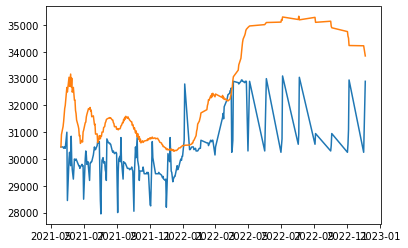

In [17]:
prediction1_1 = forecast_predict(model1, test_baput_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_baput1_1 = pd.DataFrame()
data_new_baput1_1['actual'] = x_test
data_new_baput1_1['prediction'] = data_result1_1
data_new_baput1_1.to_csv('baput_model2_adam_type2.csv')

plt.plot(y_test, data_new_baput1_1.actual)
plt.plot(y_test, data_new_baput1_1.prediction)
data_new_baput1_1

#### Type 3

In [18]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 22ms/step - loss: 0.0246 - mae: 0.1080 - mape: 1475624.3750 - val_loss: 0.0022 - val_mae: 0.0417 - val_mape: 20.8512
Epoch 2/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0241 - mae: 0.1061 - mape: 1435475.0000 - val_loss: 0.0017 - val_mae: 0.0358 - val_mape: 18.0312
Epoch 3/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0240 - mae: 0.1060 - mape: 1386530.1250 - val_loss: 0.0017 - val_mae: 0.0349 - val_mape: 17.5732
Epoch 4/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0239 - mae: 0.1055 - mape: 1349410.1250 - val_loss: 8.8053e-04 - val_mae: 0.0212 - val_mape: 11.1146
Epoch 5/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0239 - mae: 0.1045 - mape: 1383905.1250 - val_loss: 0.0034 - val_mae: 0.0540 - val_mape: 26.6444
Epoch 6/15
84/84 [==============================] - 2s 24ms/step - loss: 0.0237 - mae: 0.1058 - mape: 1393615.0000 - val_loss: 0.0015 - 

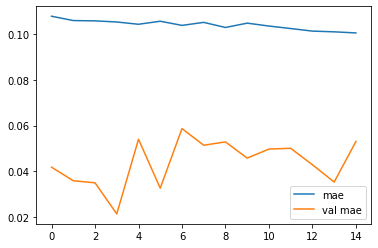

In [19]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
2422.7153 8.015491 2858.258123403133


,actual,prediction
0,30450,30894.865234
1,30450,31522.199219
2,30450,31817.945312
3,30400,32607.779297
4,30450,33019.039062
...,...,...
229,30550,36150.175781
230,31100,35951.062500
231,32950,35682.218750
232,30250,35555.464844


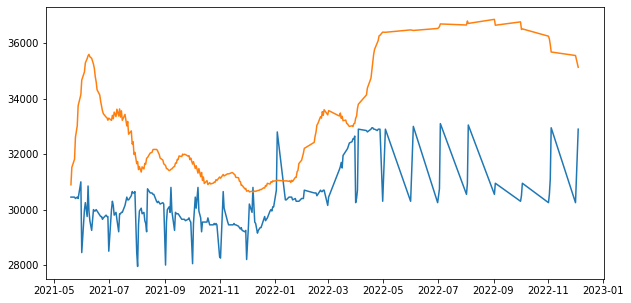

In [20]:
prediction1_2 = forecast_predict(model1, test_baput_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_baput1_2 = pd.DataFrame()
data_new_baput1_2['actual'] = x_test
data_new_baput1_2['prediction'] = data_result1_2
data_new_baput1_2.to_csv('baput_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_baput1_2.actual)
plt.plot(y_test, data_new_baput1_2.prediction)

data_new_baput1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 45ms/step - loss: 0.0874 - mae: 0.2215 - mape: 136736.3281 - val_loss: 0.0318 - val_mae: 0.1770 - val_mape: 82.5963
Epoch 2/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0718 - mae: 0.1937 - mape: 554528.8750 - val_loss: 0.0207 - val_mae: 0.1424 - val_mape: 66.2242
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0608 - mae: 0.1725 - mape: 766814.2500 - val_loss: 0.0134 - val_mae: 0.1138 - val_mape: 52.6737
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0536 - mae: 0.1647 - mape: 1170307.7500 - val_loss: 0.0085 - val_mae: 0.0898 - val_mape: 41.3394
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0484 - mae: 0.1605 - mape: 1197804.1250 - val_loss: 0.0054 - val_mae: 0.0704 - val_mape: 32.1666
Epoch 6/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0450 - mae: 0.1617 - mape: 1448799.2500 - val_loss: 0.0033 - val_mae

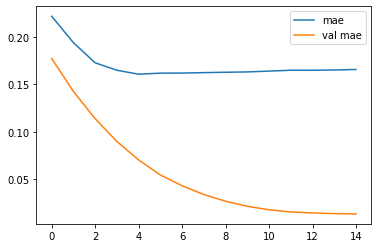

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
748.4892 2.4152734 1091.653161494071


,actual,prediction
0,30450,30046.814453
1,30450,30045.845703
2,30450,30040.910156
3,30400,30044.033203
4,30450,30038.962891
...,...,...
229,30550,30116.458984
230,31100,30124.109375
231,32950,30110.460938
232,30250,30117.464844


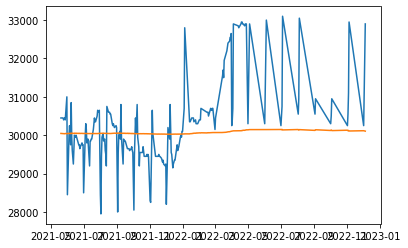

In [ ]:
prediction1_a = forecast_predict(model1_a, test_baput_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_baput1_a = pd.DataFrame()
data_new_baput1_a['actual'] = x_test
data_new_baput1_a['prediction'] = data_result1_a
data_new_baput1_a.to_csv('baput_model2_sgd_type1.csv')


plt.plot(y_test, data_new_baput1_a.actual)
plt.plot(y_test, data_new_baput1_a.prediction)

data_new_baput1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0276 - mae: 0.1258 - mape: 679445.3125 - val_loss: 5.9274e-04 - val_mae: 0.0153 - val_mape: 8.2232
Epoch 2/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0273 - mae: 0.1259 - mape: 712053.7500 - val_loss: 4.4708e-04 - val_mae: 0.0144 - val_mape: 7.5420
Epoch 3/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0270 - mae: 0.1245 - mape: 706236.8125 - val_loss: 4.9216e-04 - val_mae: 0.0137 - val_mape: 7.3323
Epoch 4/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0271 - mae: 0.1246 - mape: 681007.1250 - val_loss: 4.9003e-04 - val_mae: 0.0136 - val_mape: 7.3264
Epoch 5/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0268 - mae: 0.1243 - mape: 717635.0000 - val_loss: 4.8400e-04 - val_mae: 0.0137 - val_mape: 7.3279
Epoch 6/15
718/718 [==============================] - 7s 9ms/step - loss: 0.0267 - mae: 0.1237 - mape: 714551.4375 - val_loss

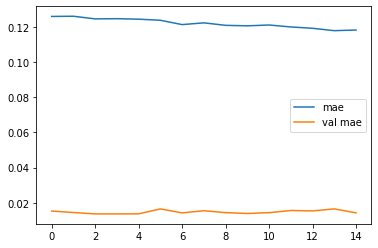

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
804.3194 2.5765486 1178.8172038106673


,actual,prediction
0,30450,29665.101562
1,30450,29716.669922
2,30450,29647.250000
3,30400,29699.279297
4,30450,29637.011719
...,...,...
229,30550,29975.279297
230,31100,29953.150391
231,32950,29954.369141
232,30250,29934.240234


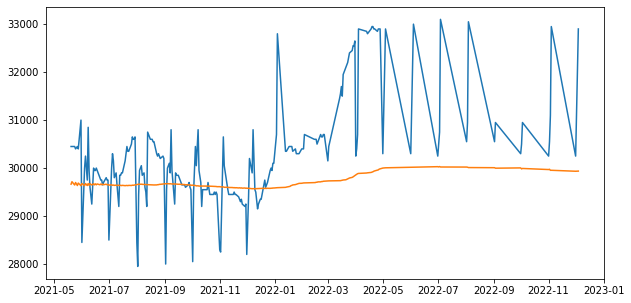

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_baput_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_baput1_a1 = pd.DataFrame()
data_new_baput1_a1['actual'] = x_test
data_new_baput1_a1['prediction'] = data_result1_a1
data_new_baput1_a1.to_csv('baput_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_baput1_a1.actual)
plt.plot(y_test, data_new_baput1_a1.prediction)
data_new_baput1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0325 - mae: 0.1341 - mape: 1219949.8750 - val_loss: 6.2988e-04 - val_mae: 0.0162 - val_mape: 8.6803
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0320 - mae: 0.1362 - mape: 1302993.5000 - val_loss: 0.0010 - val_mae: 0.0244 - val_mape: 12.6630
Epoch 3/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0318 - mae: 0.1366 - mape: 1310068.8750 - val_loss: 0.0012 - val_mae: 0.0281 - val_mape: 14.4636
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0317 - mae: 0.1379 - mape: 1335744.1250 - val_loss: 0.0014 - val_mae: 0.0311 - val_mape: 15.8549
Epoch 5/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0316 - mae: 0.1377 - mape: 1340066.2500 - val_loss: 0.0015 - val_mae: 0.0329 - val_mape: 16.7284
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0316 - mae: 0.1383 - mape: 1354096.1250 - val_loss: 0.0015 - v

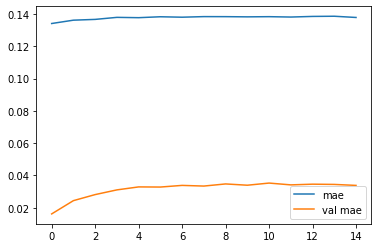

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
837.32 2.7581522 1047.5626472913207


,actual,prediction
0,30450,30599.031250
1,30450,30656.189453
2,30450,30579.755859
3,30400,30637.134766
4,30450,30568.433594
...,...,...
229,30550,30953.205078
230,31100,30927.542969
231,32950,30929.935547
232,30250,30906.582031


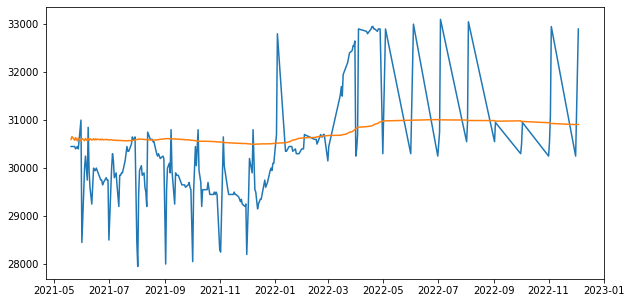

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_baput_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_baput1_a2 = pd.DataFrame()
data_new_baput1_a2['actual'] = x_test
data_new_baput1_a2['prediction'] = data_result1_a2
data_new_baput1_a2.to_csv('baput_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_baput1_a2.actual)
plt.plot(y_test, data_new_baput1_a2.prediction)

data_new_baput1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 34ms/step - loss: 0.0883 - mae: 0.2235 - mape: 52945.8984 - val_loss: 0.0336 - val_mae: 0.1821 - val_mape: 84.9751
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0741 - mae: 0.1974 - mape: 373938.7812 - val_loss: 0.0229 - val_mae: 0.1500 - val_mape: 69.7881
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0639 - mae: 0.1770 - mape: 773824.7500 - val_loss: 0.0157 - val_mae: 0.1233 - val_mape: 57.1894
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0564 - mae: 0.1675 - mape: 952253.0000 - val_loss: 0.0110 - val_mae: 0.1029 - val_mape: 47.5012
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0513 - mae: 0.1638 - mape: 1203689.5000 - val_loss: 0.0076 - val_mae: 0.0848 - val_mape: 38.9596
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0476 - mae: 0.1625 - mape: 1269988.8750 - val_loss: 0.0052 - val_mae: 

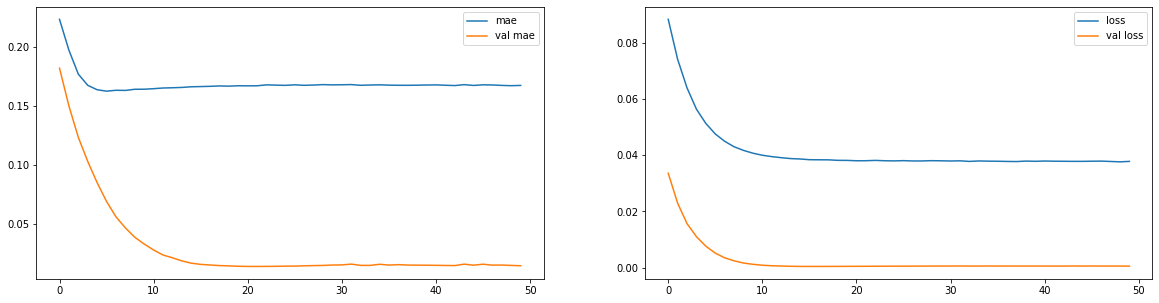

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
756.74365 2.450756 1084.9409546145819


,actual,prediction
0,30450,30391.810547
1,30450,30391.505859
2,30450,30414.361328
3,30400,30372.357422
4,30450,30373.757812
...,...,...
229,30550,30236.191406
230,31100,30243.162109
231,32950,30236.740234
232,30250,30237.429688


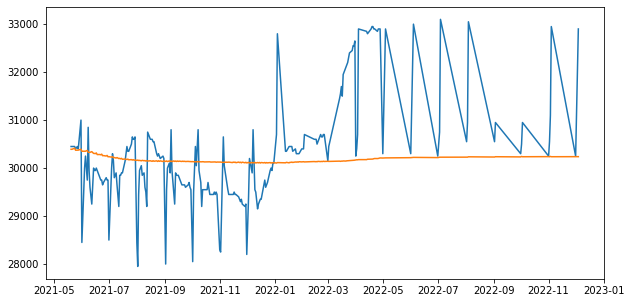

In [ ]:
prediction2 = forecast_predict(model2, test_baput_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_baput2 = pd.DataFrame()
data_new_baput2['actual'] = x_test
data_new_baput2['prediction'] = data_result2
data_new_baput2.to_csv('baput_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_baput2.actual)
plt.plot(y_test, data_new_baput2.prediction)
data_new_baput2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0278 - mae: 0.1274 - mape: 710463.3750 - val_loss: 4.9598e-04 - val_mae: 0.0184 - val_mape: 9.0156
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0273 - mae: 0.1242 - mape: 699048.5625 - val_loss: 5.1451e-04 - val_mae: 0.0189 - val_mape: 9.2207
Epoch 3/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0271 - mae: 0.1241 - mape: 673086.6875 - val_loss: 4.7870e-04 - val_mae: 0.0178 - val_mape: 8.7925
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0271 - mae: 0.1238 - mape: 736378.1250 - val_loss: 5.5820e-04 - val_mae: 0.0201 - val_mape: 9.7092
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0269 - mae: 0.1238 - mape: 683978.2500 - val_loss: 4.6794e-04 - val_mae: 0.0174 - val_mape: 8.6278
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0268 - mae: 0.1228 - mape: 669361.0000 - val_loss

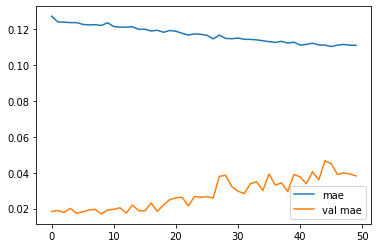

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_baput_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_baput2_1 = pd.DataFrame()
data_new_baput2_1['actual'] = x_test
data_new_baput2_1['prediction'] = data_result2_1
data_new_baput2_1.to_csv('baput_model3_sgd_type2.csv')

data_new_baput2

199/199 [==============================] - 1s 4ms/step
2132.913 6.933759 2361.2914898419467


,actual,prediction
0,30450,30391.810547
1,30450,30391.505859
2,30450,30414.361328
3,30400,30372.357422
4,30450,30373.757812
...,...,...
229,30550,30236.191406
230,31100,30243.162109
231,32950,30236.740234
232,30250,30237.429688


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0316 - mae: 0.1329 - mape: 1261680.7500 - val_loss: 8.5664e-04 - val_mae: 0.0271 - val_mape: 12.7194
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0319 - mae: 0.1357 - mape: 1453469.7500 - val_loss: 5.9593e-04 - val_mae: 0.0212 - val_mape: 10.1677
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0319 - mae: 0.1368 - mape: 1444402.3750 - val_loss: 5.5248e-04 - val_mae: 0.0201 - val_mape: 9.7303
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0316 - mae: 0.1360 - mape: 1496700.7500 - val_loss: 5.1650e-04 - val_mae: 0.0191 - val_mape: 9.2976
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0318 - mae: 0.1378 - mape: 1419719.6250 - val_loss: 4.9082e-04 - val_mae: 0.0182 - val_mape: 8.9539
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0314 - mae: 0.1365 - mape: 1496911.2500 - val_lo

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_baput_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_baput2_2 = pd.DataFrame()
data_new_baput2_2['actual'] = x_test
data_new_baput2_2['prediction'] = data_result2_2
data_new_baput2_2.to_csv('baput_model3_sgd-type3.csv')

data_new_baput2_2

### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

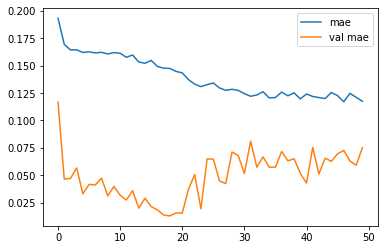

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_baput_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_baput2_a = pd.DataFrame()
data_new_baput2_a['actual'] = x_test
data_new_baput2_a['prediction'] = data_result2_a
data_new_baput2_a.to_csv('baput_model3_adam-type1.csv')

data_new_baput2_a

131/131 [==============================] - 1s 7ms/step
1390.8949 4.5751786 1704.9012434742372


,actual,prediction
0,30450,29750.357422
1,30450,29287.304688
2,30450,29157.056641
3,30400,28636.757812
4,30450,30634.296875
...,...,...
229,30550,34870.792969
230,31100,34295.031250
231,32950,34909.652344
232,30250,34547.031250


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0219 - mae: 0.1039 - mape: 770318.1875 - val_loss: 0.0014 - val_mae: 0.0312 - val_mape: 15.6959
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0213 - mae: 0.1039 - mape: 823855.7500 - val_loss: 0.0026 - val_mae: 0.0468 - val_mape: 23.1025
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0199 - mae: 0.0995 - mape: 674156.7500 - val_loss: 6.7930e-04 - val_mae: 0.0232 - val_mape: 10.9083
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0208 - mae: 0.1000 - mape: 776436.7500 - val_loss: 4.6486e-04 - val_mae: 0.0185 - val_mape: 9.0383
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0207 - mae: 0.0998 - mape: 815504.5000 - val_loss: 0.0032 - val_mae: 0.0529 - val_mape: 25.9815
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0204 - mae: 0.0988 - mape: 694855.8750 - val_loss: 4.6334

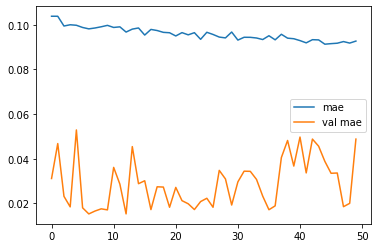

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2190.0771 7.182327 2348.9368871896068


,actual,prediction
0,30450,27852.531250
1,30450,27392.376953
2,30450,27499.335938
3,30400,27113.363281
4,30450,28270.691406
...,...,...
229,30550,31722.160156
230,31100,31376.662109
231,32950,31831.333984
232,30250,31625.218750


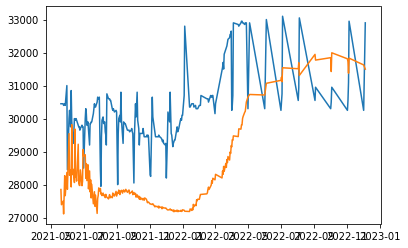

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_baput_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_baput2_a1 = pd.DataFrame()
data_new_baput2_a1['actual'] = x_test
data_new_baput2_a1['prediction'] = data_result2_a1
data_new_baput2_a1.to_csv('baput_model3_adam-type2.csv')

plt.plot(y_test, data_new_baput2_a1.actual)
plt.plot(y_test, data_new_baput2_a1.prediction)
data_new_baput2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0259 - mae: 0.1122 - mape: 1319598.3750 - val_loss: 0.0011 - val_mae: 0.0273 - val_mape: 13.6508
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0249 - mae: 0.1104 - mape: 1293742.2500 - val_loss: 9.2163e-04 - val_mae: 0.0244 - val_mape: 12.2401
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0252 - mae: 0.1095 - mape: 1300917.0000 - val_loss: 0.0011 - val_mae: 0.0281 - val_mape: 14.0448
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0246 - mae: 0.1078 - mape: 1287614.5000 - val_loss: 0.0013 - val_mae: 0.0310 - val_mape: 15.3866
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0247 - mae: 0.1074 - mape: 1327761.6250 - val_loss: 0.0020 - val_mae: 0.0389 - val_mape: 19.1441
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0247 - mae: 0.1081 - mape: 1258829.1250 - val_loss: 0.0024 - 

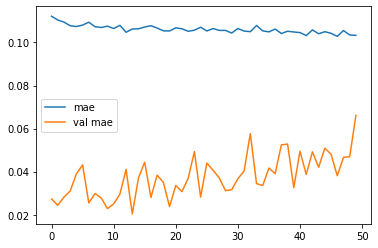

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
1366.5839 4.493851 1706.4651329576002


,actual,prediction
0,30450,29043.498047
1,30450,28519.517578
2,30450,30413.003906
3,30400,29321.257812
4,30450,29432.628906
...,...,...
229,30550,35123.214844
230,31100,34733.769531
231,32950,34580.621094
232,30250,34101.078125


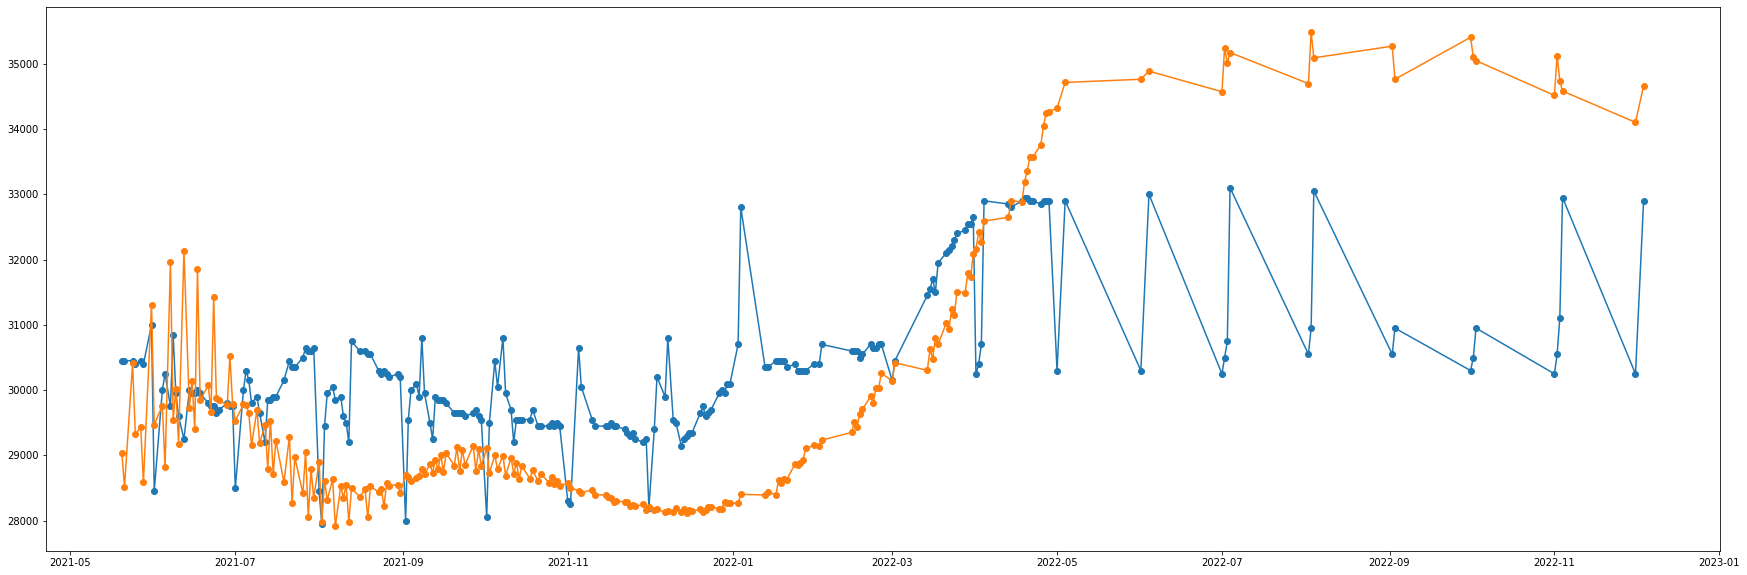

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_baput_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_baput2_a2 = pd.DataFrame()
data_new_baput2_a2['actual'] = x_test
data_new_baput2_a2['prediction'] = data_result2_a2
data_new_baput2_a2.to_csv('baput_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_baput2_a2.actual, '-o')
plt.plot(y_test,data_new_baput2_a2.prediction, '-o')
data_new_baput2_a2